In [6]:
import keras
print("keras version : ",keras.__version__)

keras version :  2.3.1


In [12]:
import cv2
import numpy as np
from Hoosh.HodaDatasetReader import read_hoda_cdb
print('Reading Train 60000.cdb ...')
train_images, train_labels = read_hoda_cdb('DigitDB/Train 60000.cdb')
print ("train shape : ",np.shape(train_images[1]))
dataset=[]
for idx,image in enumerate(train_images):
    dataset.append( cv2.resize(image,(50,50)))


Reading Train 60000.cdb ...
train shape :  (20, 21)


In [13]:
dataset=np.reshape(dataset,(60000,2500))
dataset=dataset[1:1000]
np.shape(dataset)
dataset = dataset.astype('float32') / 255.

In [14]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 200  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(2500,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(2500, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

create a separate encoder model:

In [15]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)


the decoder model:

In [16]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

we'll configure our model to use a per-pixel binary crossentropy loss, and the Adadelta optimizer:

In [17]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

We will normalize all values between 0 and 1 and we will flatten the 50x50 images into vectors of size 784.

train our autoencoder for 50 epochs:

In [18]:
autoencoder.fit(dataset, dataset,
                epochs=100,
                batch_size=256,
                shuffle=True
                #,validation_data=(x_test, x_test)
               )

Epoch 1/100
999/999 [==============================] - 0s 313us/step - loss: 0.6965
Epoch 2/100
999/999 [==============================] - 0s 178us/step - loss: 0.6931
Epoch 3/100
999/999 [==============================] - 0s 219us/step - loss: 0.6908
Epoch 4/100
999/999 [==============================] - 0s 244us/step - loss: 0.6889
Epoch 5/100
999/999 [==============================] - 0s 219us/step - loss: 0.6868
Epoch 6/100
999/999 [==============================] - 0s 234us/step - loss: 0.6845
Epoch 7/100
999/999 [==============================] - 0s 273us/step - loss: 0.6818
Epoch 8/100
999/999 [==============================] - 0s 199us/step - loss: 0.6785
Epoch 9/100
999/999 [==============================] - 0s 258us/step - loss: 0.6746
Epoch 10/100
999/999 [==============================] - 0s 269us/step - loss: 0.6700
Epoch 11/100
999/999 [==============================] - 0s 210us/step - loss: 0.6649
Epoch 12/100
999/999 [==============================] - 0s 213us/step - lo

In [19]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(dataset)
decoded_imgs = decoder.predict(encoded_imgs)

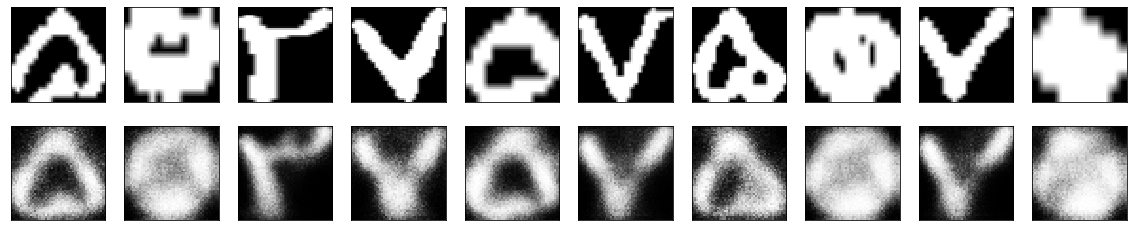

In [21]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(dataset[i].reshape(50, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(50, 50))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()